## Monitoring Vibration Data
Notebook to manually monitor and assess the vibration data from the IoT Connxt platform and the IFM sensors. The notebook performs the following steps:
- reading necessary packages and authenticating
- retrieving time series objects
- retrieving recent time series
- visualizing the data

In [3]:
import os
import requests
from datetime import datetime
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn

Authenticate yourself to retrieve data in Lizard. For this, you need an API key from Lizard.

In [4]:
# Get API key from env file
load_dotenv()

username = '__key__'
password = os.getenv("LIZARD_API_KEY")
json_headers = {
            "username": username,
            "password": password,
            "Content-Type": "application/json",
        }

### Retrieve time series objects from pumping station Zuidbroek

In [5]:
# Define gemaal based on naam in Damo
gemaal = "Rg. Zuidbroek"

url = "https://demo.lizard.net/api/v4/timeseries/?location__name__startswith="+gemaal

# Get the data from the API
print(url)
print(requests.get(url,headers=json_headers,params= {'page_size':'10000'}).json())
querydata = requests.get(url,headers=json_headers,params= {'page_size':'10000'}).json()['results']
timeseries_list = pd.DataFrame(querydata)


https://demo.lizard.net/api/v4/timeseries/?location__name__startswith=Rg. Zuidbroek
{'count': 47, 'next': None, 'previous': None, 'results': [{'url': 'https://demo.lizard.net/api/v4/timeseries/d7b8f370-7f19-4565-8fd8-5b8b65303591/', 'uuid': 'd7b8f370-7f19-4565-8fd8-5b8b65303591', 'code': 'WNS9688::second::1::120', 'name': 'WNS9688', 'description': '', 'start': '2013-02-11T08:00:00Z', 'end': '2023-03-21T10:14:00Z', 'value_type': 'float', 'last_value': -3.522, 'interval': 120, 'observation_type': {'url': 'https://demo.lizard.net/api/v4/observationtypes/14/', 'id': 14, 'code': 'WNS9688', 'parameter': 'Waterhoogte', 'unit': 'm', 'scale': 'interval', 'description': '', 'domain_values': None, 'reference_frame': 'NAP', 'compartment': 'AW', 'created': '2015-06-19T09:47:29.345611Z', 'last_modified': '2019-06-25T07:26:10.441021Z'}, 'datasource': None, 'supplier': None, 'supplier_code': None, 'location': {'url': 'https://demo.lizard.net/api/v4/locations/02f1327c-2ee1-4209-9834-35cb14492aef/', 'uu

### Retrieving time series and displaying the latest observation in a table


Retrieve the latest value for all time series objects found for pumping station Zuidbroek and present it in a table based on recency.

In [ ]:
timeseries_list['location'] = timeseries_list['location'].apply(lambda x: x['name'])
timeseries_list['last_modified'] = pd.to_datetime(timeseries_list['last_modified'])
timeseries_list = timeseries_list.sort_values(by='last_modified', ascending=False)
timeseries_list['last_modified'] = timeseries_list['last_modified'].dt.tz_convert('CET').dt.strftime('%Y-%m-%d %H:%M:%S')
timeseries_list = timeseries_list[['uuid','location', 'name', 'last_modified', 'last_value']]
timeseries_list

,uuid,location,name,last_modified,last_value
2,ab3e1a02-c3c8-48a3-af8d-51935eabf3c0,"Rg. Zuidbroek, kelder",WNS2369.h,2024-12-05 08:05:46,184.310000
37,7659a386-dceb-4019-9fa5-ebcdfe91039e,"Rg. Zuidbroek, kelder",WNS9688,2024-12-05 08:05:07,-3.508000
36,e26e4f97-7390-4b60-8fb2-d9f6f01a2259,"Rg. Zuidbroek, kelder",WNS2368,2024-12-05 07:55:59,384.000000
21,25bc0196-f33b-4261-a95e-f17081ad4a4f,"Rg. Zuidbroek, pomp 2, sensor 5",vibration.a.rms.meting,2024-12-05 06:05:35,0.096000
8,bbd49751-9642-4e7c-ac39-7703ad27a7a8,"Rg. Zuidbroek, pomp 1, sensor 1",vibration.v.meting,2024-12-05 06:05:34,0.000000
18,6f685d38-2d6f-4bd7-a1cb-a73bfe8b8f41,"Rg. Zuidbroek, pomp 2, sensor 4",vibration.a.rms.meting,2024-12-05 06:05:32,0.102000
24,d1a3a8a9-69f5-4fb8-95e1-57156d839d51,"Rg. Zuidbroek, pomp 2, sensor 6",vibration.a.rms.meting,2024-12-05 06:05:31,0.095000
10,cae3e7f8-e246-4e7e-9730-bcb8a672de45,"Rg. Zuidbroek, pomp 1, sensor 1",vibration.a.peak.meting,2024-12-05 06:05:29,0.374000
20,8f92d4a9-4a16-44d1-9ee0-ab3a00a5311d,"Rg. Zuidbroek, pomp 2, sensor 5",vibration.v.meting,2024-12-05 06:05:29,0.000000
14,1fbab1b5-1390-46d4-bc32-97db161ec545,"Rg. Zuidbroek, pomp 1, sensor 3",vibration.v.meting,2024-12-05 06:05:29,0.000000


### Visualizing Data
Use the UUID of a time series to retrieve and display the data for this parameter from the past week in a graph.

In [11]:
# make list of uuids for all rows in timeserieslist with sensor in the name
uuids = timeseries_list[timeseries_list['location'].str.contains('IoT sensor', case=False)]['uuid'].tolist()
uuids = timeseries_list[timeseries_list['location'].str.contains('sensor', case=False)]['uuid'].tolist()

start = (datetime.now() - pd.Timedelta(days=14)).strftime('%Y-%m-%dT%H:%M:%SZ')
end = (datetime.now() - pd.Timedelta(days=0)).strftime('%Y-%m-%dT%H:%M:%SZ')
base_url = "https://hhnk.lizard.net/api/v4/timeseries/{}/events/"

all_counts_list = []

for uuid in uuids:
    url = base_url.format(uuid)
    time_series_events = pd.DataFrame(requests.get(url=url, headers=json_headers, params={'start': start, 'end': end, 'fields': 'value', 'page_size': '10000000'}).json()['results'])
    
    # Process the time series events
    time_series_events['time'] = time_series_events['time'].str.replace(r'\.\d+Z', 'Z', regex=True) # remove milliseconds
    time_series_events['timestamp'] = pd.to_datetime(time_series_events['time'])
    time_series_events['date'] = time_series_events['timestamp'].dt.date
    time_series_events['count'] = 1
    ts_count = time_series_events.groupby('date').count()
    ts_count = ts_count[['count']]
    # Get based on uuid the location from timeseries_list and use as column name
    location = timeseries_list[timeseries_list['uuid'] == uuid]['location'].values[0]
    ts_count.columns = [location]
    
    all_counts_list.append(ts_count)

# Merge all counts into one DataFrame
all_counts_df = pd.concat(all_counts_list, axis=1)
all_counts_df = all_counts_df.iloc[1:]
all_counts_df = all_counts_df.sort_index()
all_counts_df.columns = all_counts_df.columns.str.replace('Rg. Zuidbroek ', '')
all_counts_df.columns = all_counts_df.columns.str.replace('Rg. Zuidbroek,', '')

# Show table with columns as rows and dates as columns and columns descending based on date
counts_df = all_counts_df.T
counts_df = counts_df.sort_index(ascending=True)
counts_df.index.name = 'location'
counts_df

date,2024-11-21,2024-11-22,2024-11-24,2024-11-25,2024-11-26,2024-11-27,2024-11-28,2024-11-29,2024-11-30,2024-12-01,2024-12-02,2024-12-03,2024-12-04,2024-12-05
location,,,,,,,,,,,,,,
"pomp 1, sensor 1",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 1",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 1",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 2",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 2",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 2",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 3",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 3",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0
"pomp 1, sensor 3",NaN,NaN,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,192.0


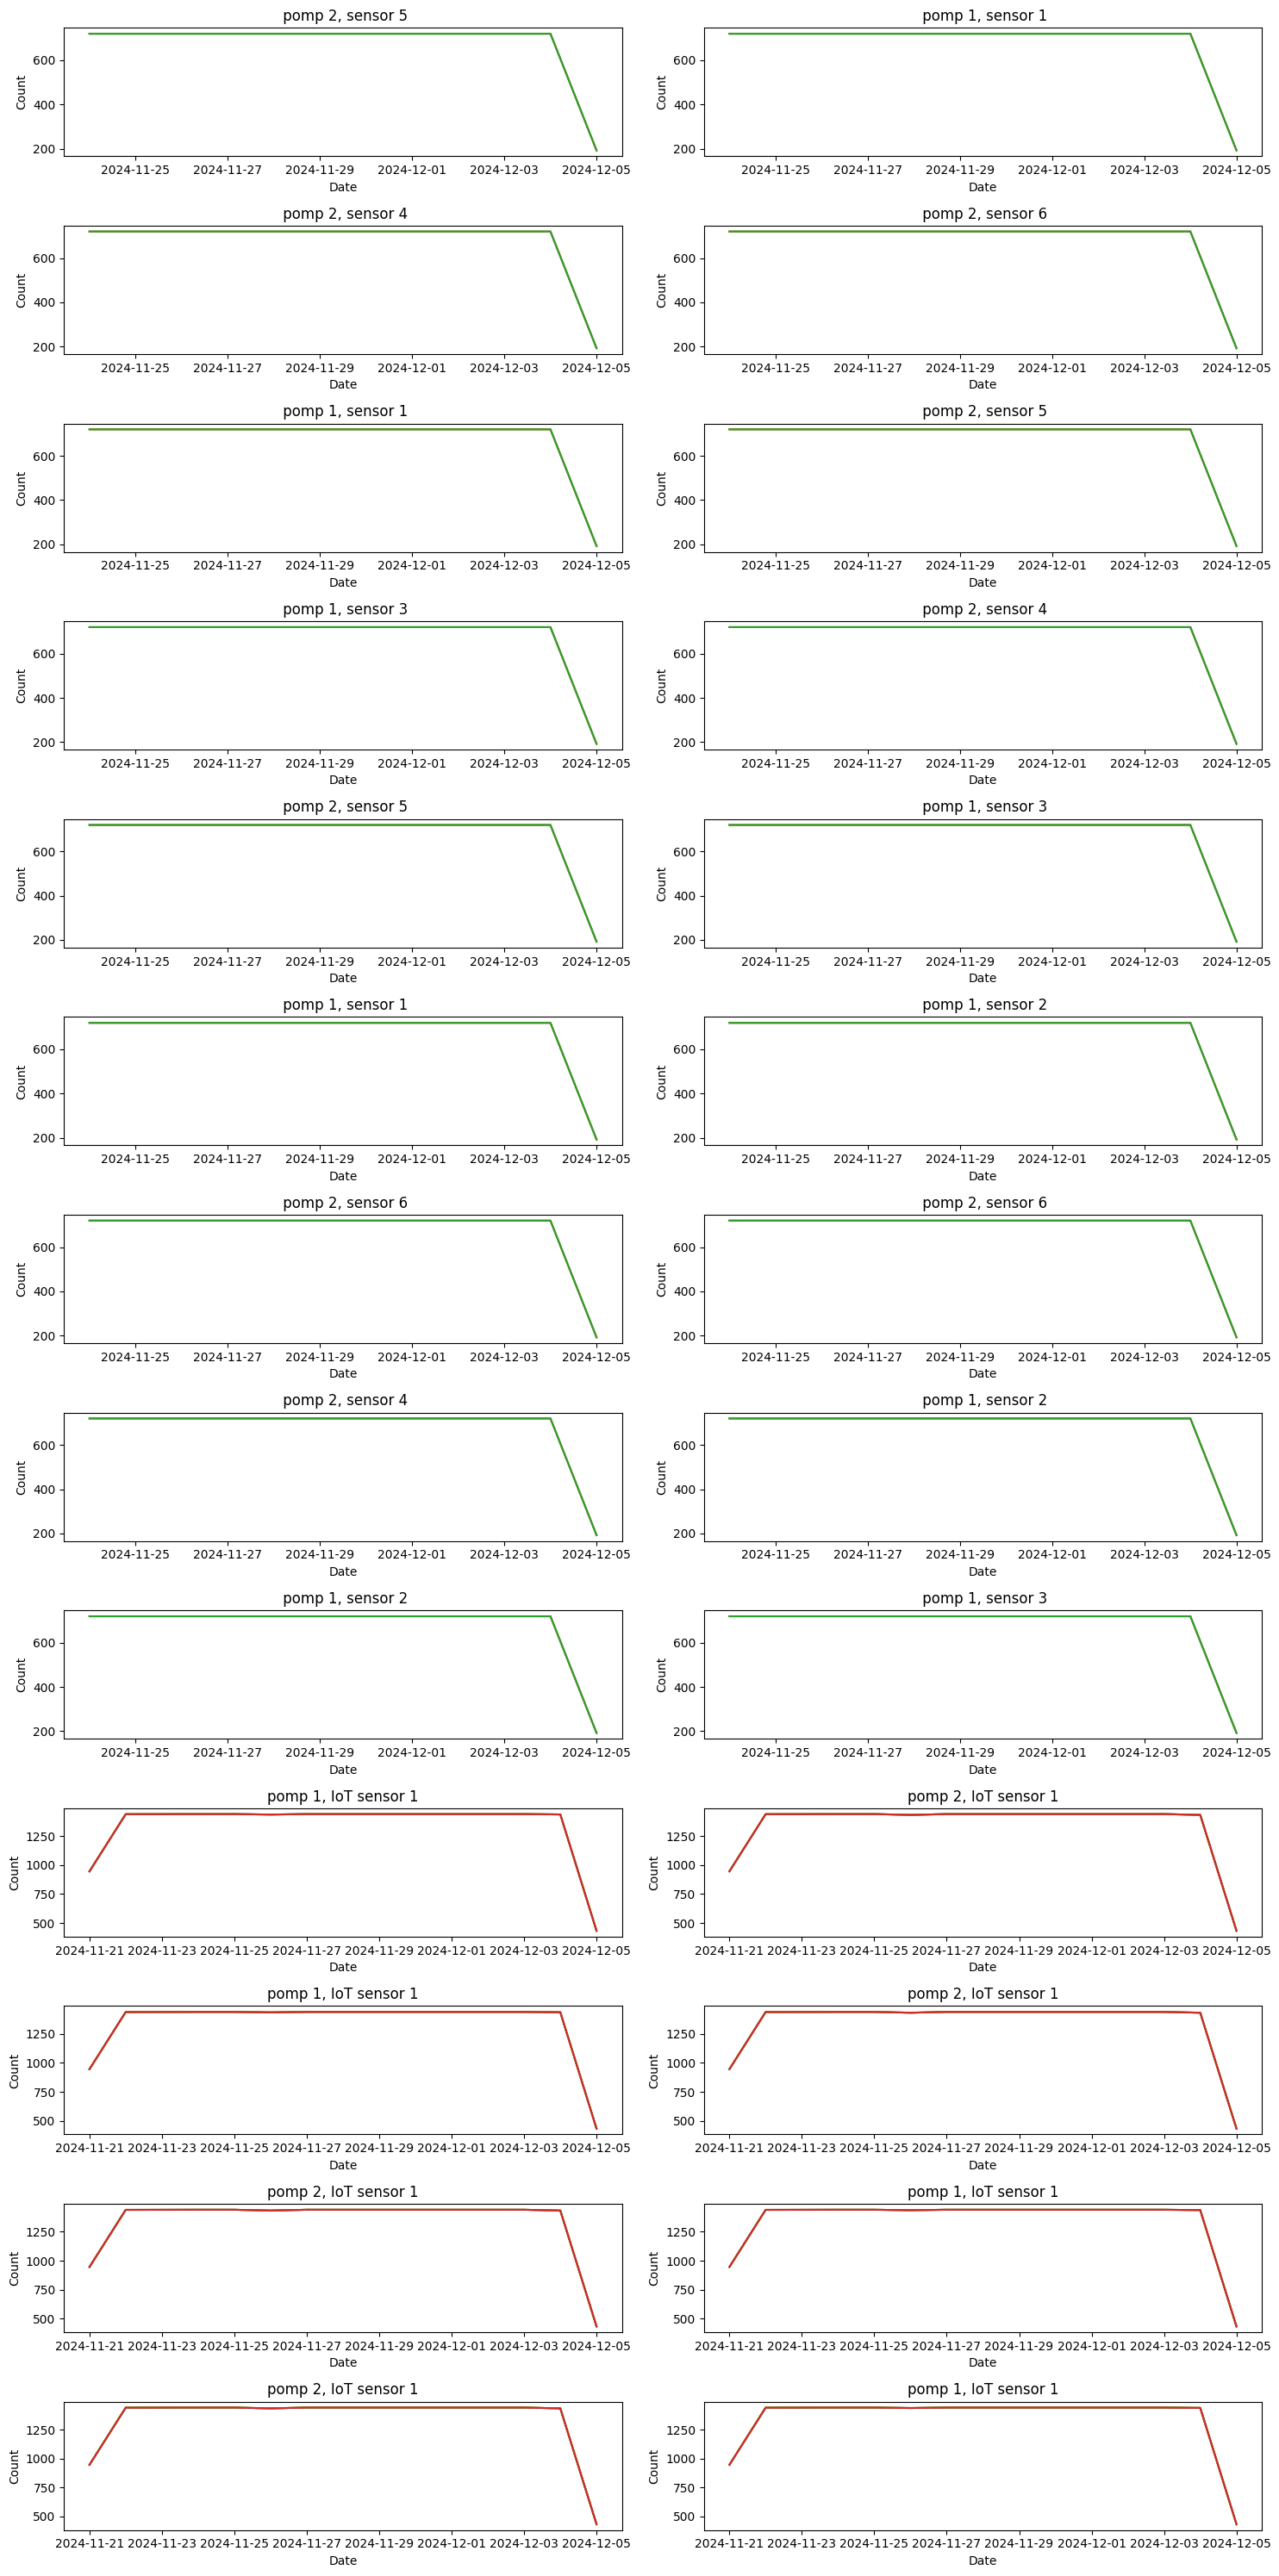

In [12]:
fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(15, 30))
axes = axes.flatten()

for i, column in enumerate(all_counts_df.columns):
    all_counts_df[column].plot(ax=axes[i], title=column)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Count')
    axes[i].get_legend().remove()

plt.tight_layout()
plt.show()
